In [1]:
import os
import argparse
from tqdm.auto import tqdm
import json

import torch
from accelerate import Accelerator
import matplotlib.pyplot as plt


home_dir = os.path.expanduser("~")
import sys

from constant import *

from pipeline_stable_diffusion_mask import StableDiffusionMaskPipeline
from mask_attention_processor_test import MaskAttnProcessor2_0

from attn_map_utils import *

/home/seulgi/anaconda3/envs/dynamic_adapter/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
custom_model_path = "custom-model-path"
mask_token = "sks"
modifier_token = "sks"
device = "cuda:1"
seed = 43
num_samples = 1
num_inference_steps = 50

In [3]:
# load pipeline
pipeline = StableDiffusionMaskPipeline.from_pretrained(
    custom_model_path,
)
pipeline.safety_checker = None
unet = pipeline.unet
attn_procs = {}
for name in unet.attn_processors.keys():
    cross_attention_dim = (
        None
        if name.endswith("attn1.processor")
        else unet.config.cross_attention_dim
    )
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]
    if cross_attention_dim is None:
        attn_procs[name] = MaskAttnProcessor2_0(
        )
    else:
        attn_procs[name] = MaskAttnProcessor2_0(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim,
        )
unet.set_attn_processor(attn_procs)
pipeline.unet = register_cross_attention_hook(pipeline.unet)
mask_token_id = pipeline.tokenizer.convert_tokens_to_ids(f"{mask_token}</w>")

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.78it/s]


In [4]:
pipeline.to(device)
generator = torch.Generator(device=device).manual_seed(seed)

In [5]:
from diffusers.utils.torch_utils import randn_tensor
batch_size = 1 * num_samples
num_channels_latents = pipeline.unet.config.in_channels
height = int(pipeline.unet.config.sample_size * pipeline.vae_scale_factor) // pipeline.vae_scale_factor
width = int(pipeline.unet.config.sample_size * pipeline.vae_scale_factor) // pipeline.vae_scale_factor
shape = (batch_size, num_channels_latents, height, width)
latents = randn_tensor(shape, generator=generator, device=pipeline.device, dtype=pipeline.text_encoder.dtype)
print(latents.shape)

torch.Size([1, 4, 64, 64])


In [6]:
# # prepare prompt list
target_name = os.path.basename(custom_model_path)
class_type = TARGET2CLASS_MAPPING[target_name]

In [7]:
prompts = [
    "a {} under the cherry blossms"
]

In [8]:
idx = 0
prompt = prompts[idx].format(f"{modifier_token} {class_type}")
pre_prompt = f"{modifier_token} {class_type}"
print(f"{prompt}\n{pre_prompt}")

a sks toy under the cherry blossms
sks toy


In [25]:
latents = randn_tensor(shape, generator=generator, device=pipeline.device, dtype=pipeline.text_encoder.dtype)
print(latents.shape)

torch.Size([1, 4, 64, 64])


In [32]:
def save_intermediate(step, timestep, latents):
    # latents를 이미지로 변환
    with torch.no_grad():
        latents = 1 / 0.18215 * latents
        image = pipeline.vae.decode(latents).sample
    
    # 이미지 후처리
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")
    image = Image.fromarray(image[0])
    
    # 이미지 저장
    intermediate_images.append(image)

In [34]:
clear_memory()
intermediate_images = []
MaskAttnProcessor2_0.mask = None
MaskAttnProcessor2_0.mask_stack = []
result = pipeline(
    prompt=prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=7.5,
    generator=generator,
    mask_token_id=mask_token_id,
    pre_prompt=pre_prompt,
    attn_scale=1.0,
    latents=latents,
    callback=save_intermediate,
    callback_steps=5,
).images

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.61it/s]


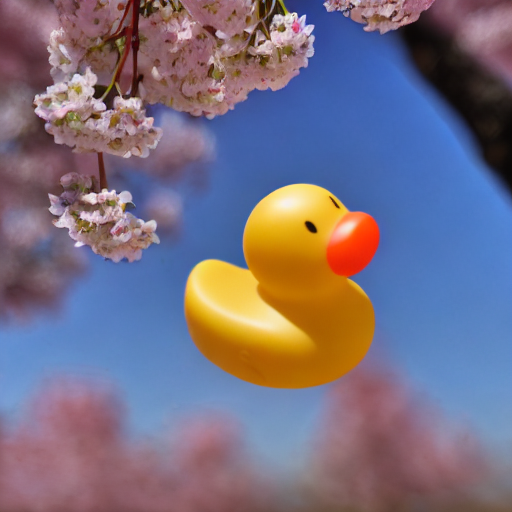

In [27]:
# fig, axes = plt.subplots(2, 5, figsize=(10, 4))
# axes = axes.flatten()
# for i in range(10):
#     axes[i].imshow(result[i])
#     axes[i].axis('off')
# plt.tight_layout()
# plt.show()
result[0]

In [63]:
result[0].save(f"./show_mask/gen_image.jpg")

In [54]:
mask_attn_map.keys()

dict_keys([25])

In [28]:
map_stack = []
for _, map in mask_attn_map[25].items():
    map_stack.append(map)

In [29]:
mask = torch.stack(map_stack, dim=0).mean(dim=0)
mask = (mask > mask.mean()).int()

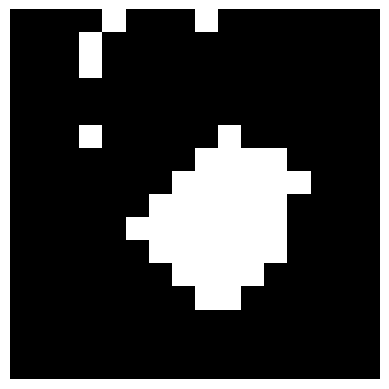

In [30]:
plt.imshow(mask.squeeze().cpu(), cmap='gray')
plt.axis('off')
plt.show()

In [31]:
image_array = (mask.squeeze().cpu().numpy() * 255).astype(np.uint8)
image = Image.fromarray(image_array)
image = image.resize((512, 512), resample=Image.NEAREST)
image.save("save-path")